## Importing libraries

In [11]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, make_scorer
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform
from nltk.corpus import stopwords

In [12]:
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/atharvavyas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/atharvavyas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Importing Data

In [13]:
# Load Dataset
df = pd.read_csv("train.csv")

# Display first few rows
display(df.head(10))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Data cleaning

In [14]:
# First, let's see original proportions
print("Original class proportions:")
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f"\n{column}:")
    print(df[column].value_counts(normalize=True))

# Create a stratification column that combines all labels
df['label_combo'] = df.apply(lambda x: '_'.join([str(x['toxic']), 
                                                str(x['severe_toxic']),
                                                str(x['obscene']), 
                                                str(x['threat']),
                                                str(x['insult']), 
                                                str(x['identity_hate'])]), axis=1)

# Get the proportion of each combination
combo_proportions = df['label_combo'].value_counts(normalize=True)

# Calculate samples needed from each combination to maintain exact proportions
n_samples = 50000
samples_per_combo = (combo_proportions * n_samples).round().astype(int)

# Sample from each combination separately
dfs = []
for combo, n in samples_per_combo.items():
    if n > 0:  # only sample if we need at least 1 sample
        temp_df = df[df['label_combo'] == combo].sample(n=n, random_state=42)
        dfs.append(temp_df)

# Combine all sampled dataframes
df_reduced = pd.concat(dfs)

# Remove the helper column
df_reduced = df_reduced.drop('label_combo', axis=1)

# Verify the new proportions
print("\nReduced dataset class proportions:")
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f"\n{column}:")
    print(df_reduced[column].value_counts(normalize=True))

print(f"\nFinal dataset size: {len(df_reduced)}")

Original class proportions:

toxic:
toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64

severe_toxic:
severe_toxic
0    0.990004
1    0.009996
Name: proportion, dtype: float64

obscene:
obscene
0    0.947052
1    0.052948
Name: proportion, dtype: float64

threat:
threat
0    0.997004
1    0.002996
Name: proportion, dtype: float64

insult:
insult
0    0.950636
1    0.049364
Name: proportion, dtype: float64

identity_hate:
identity_hate
0    0.991195
1    0.008805
Name: proportion, dtype: float64

Reduced dataset class proportions:

toxic:
toxic
0    0.904162
1    0.095838
Name: proportion, dtype: float64

severe_toxic:
severe_toxic
0    0.99002
1    0.00998
Name: proportion, dtype: float64

obscene:
obscene
0    0.947001
1    0.052999
Name: proportion, dtype: float64

threat:
threat
0    0.99702
1    0.00298
Name: proportion, dtype: float64

insult:
insult
0    0.950601
1    0.049399
Name: proportion, dtype: float64

identity_hate:
identity_hate
0    0.99116
1    0.00884

In [15]:
# Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenization
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

# Apply preprocessing
df_reduced['cleaned_text'] = df_reduced['comment_text'].astype(str).apply(preprocess_text)

# Assigning Sentiment Scores Using VADER
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df_reduced['sentiment_score'] = df_reduced['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/atharvavyas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
# Define Sentiment Categories Based on Thresholds
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_reduced['sentiment'] = df_reduced['sentiment_score'].apply(classify_sentiment)

# Define Toxicity Classification Labels
df_reduced['toxic_label'] = (df_reduced[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0).astype(int)

In [17]:
# Define Severity Levels
def severity_level(row):
    severity_score = row[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
    if severity_score == 0:
        return 'Non-Toxic'
    elif severity_score == 1:
        return 'Mild'
    elif severity_score == 2:
        return 'Moderate'
    else:
        return 'Severe'

df_reduced['toxicity_severity'] = df_reduced.apply(severity_level, axis=1)

# Feature Extraction using TF-IDF and Count Vectorization
vectorizer_tfidf = TfidfVectorizer(max_features=10000)
vectorizer_count = CountVectorizer(max_features=10000)
X_tfidf = vectorizer_tfidf.fit_transform(df_reduced['cleaned_text'])
X_count = vectorizer_count.fit_transform(df_reduced['cleaned_text'])
X_combined = hstack([X_tfidf, X_count])
y = df_reduced['toxic_label']

In [18]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

## Final Models (3 of them)

### SVM

#### Initial Model

In [19]:
# Train SVM Model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_prob = svm_model.predict_proba(X_test)[:, 1]

# Print classification report
print("SVM Classification Report:\n", classification_report(y_test, svm_pred))

# Print ROC AUC Score
print("SVM ROC AUC Score:", roc_auc_score(y_test, svm_prob))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      8989
           1       0.76      0.73      0.74      1012

    accuracy                           0.95     10001
   macro avg       0.86      0.85      0.86     10001
weighted avg       0.95      0.95      0.95     10001

SVM ROC AUC Score: 0.9357743236463363


#### Final SVM Model

In [20]:
# Run SVM with these parameters
# Best parameters for SVM: {'C': 0.1}
svm_model2 = SVC(kernel='linear', C=0.1, probability=True)
svm_model2.fit(X_train, y_train)
svm_pred2 = svm_model2.predict(X_test)
svm_prob2 = svm_model2.predict_proba(X_test)[:, 1]

# Print Classification Report
print("SVM Classification Report:\n", classification_report(y_test, svm_pred2))

# Print ROC AUC Score
print("SVM ROC AUC Score:", roc_auc_score(y_test, svm_prob2))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      8989
           1       0.88      0.63      0.74      1012

    accuracy                           0.95     10001
   macro avg       0.92      0.81      0.86     10001
weighted avg       0.95      0.95      0.95     10001

SVM ROC AUC Score: 0.9491044610078986


#### Plot

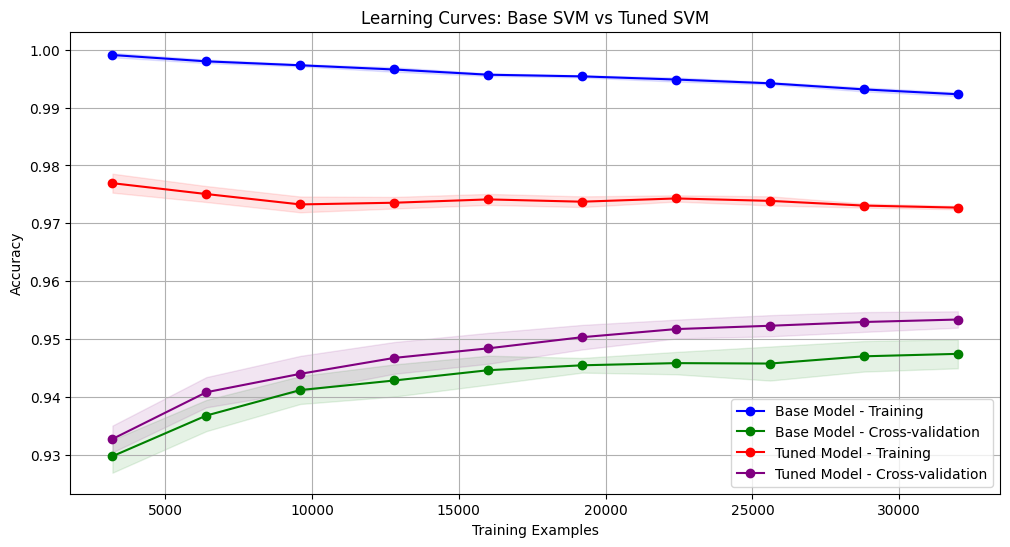


Final Scores:
Base Model:
Training Accuracy: 0.9923 (+/- 0.0006)
Cross-validation Accuracy: 0.9475 (+/- 0.0050)

Tuned Model:
Training Accuracy: 0.9727 (+/- 0.0006)
Cross-validation Accuracy: 0.9534 (+/- 0.0028)


In [21]:
from sklearn.model_selection import learning_curve

def plot_comparative_learning_curves(base_model, tuned_model, X, y, cv):
    # Set up the figure
    plt.figure(figsize=(12, 6))
    
    # Calculate learning curves for base model
    train_sizes, train_scores_base, val_scores_base = learning_curve(
        base_model, X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    # Calculate learning curves for tuned model
    train_sizes, train_scores_tuned, val_scores_tuned = learning_curve(
        tuned_model, X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    # Calculate means and stds
    train_mean_base = np.mean(train_scores_base, axis=1)
    train_std_base = np.std(train_scores_base, axis=1)
    val_mean_base = np.mean(val_scores_base, axis=1)
    val_std_base = np.std(val_scores_base, axis=1)
    
    train_mean_tuned = np.mean(train_scores_tuned, axis=1)
    train_std_tuned = np.std(train_scores_tuned, axis=1)
    val_mean_tuned = np.mean(val_scores_tuned, axis=1)
    val_std_tuned = np.std(val_scores_tuned, axis=1)
    
    # Plot base model curves
    plt.plot(train_sizes, train_mean_base, 'o-', color='blue', label='Base Model - Training')
    plt.fill_between(train_sizes, train_mean_base - train_std_base, 
                     train_mean_base + train_std_base, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean_base, 'o-', color='green', label='Base Model - Cross-validation')
    plt.fill_between(train_sizes, val_mean_base - val_std_base,
                     val_mean_base + val_std_base, alpha=0.1, color='green')
    
    # Plot tuned model curves
    plt.plot(train_sizes, train_mean_tuned, 'o-', color='red', label='Tuned Model - Training')
    plt.fill_between(train_sizes, train_mean_tuned - train_std_tuned,
                     train_mean_tuned + train_std_tuned, alpha=0.1, color='red')
    
    plt.plot(train_sizes, val_mean_tuned, 'o-', color='purple', label='Tuned Model - Cross-validation')
    plt.fill_between(train_sizes, val_mean_tuned - val_std_tuned,
                     val_mean_tuned + val_std_tuned, alpha=0.1, color='purple')
    
    # Add labels and title
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves: Base SVM vs Tuned SVM')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Show the plot
    plt.show()
    
    # Print final scores
    print("\nFinal Scores:")
    print("Base Model:")
    print(f"Training Accuracy: {train_mean_base[-1]:.4f} (+/- {train_std_base[-1]*2:.4f})")
    print(f"Cross-validation Accuracy: {val_mean_base[-1]:.4f} (+/- {val_std_base[-1]*2:.4f})")
    print("\nTuned Model:")
    print(f"Training Accuracy: {train_mean_tuned[-1]:.4f} (+/- {train_std_tuned[-1]*2:.4f})")
    print(f"Cross-validation Accuracy: {val_mean_tuned[-1]:.4f} (+/- {val_std_tuned[-1]*2:.4f})")

# Use the function with your models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Assuming your base and tuned models are named like this:
# base_svm = SVC(kernel='linear')  # Your original SVM model
# tuned_svm = your best model after tuning

plot_comparative_learning_curves(
    svm_model,  # Your base SVM model
    svm_model2,  # Your tuned SVM model
    X_train, 
    y_train,
    cv=cv
)

### Gradient Boosting Classifer

#### Initial Model

In [22]:
# Train Gradient Boosting Model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_prob = gb_model.predict_proba(X_test)[:, 1]

# Print Classification Report
print("Gradient Boosting Classification Report:\n", classification_report(y_test, gb_pred))

# Print ROC-AUC score
print(f"ROC-AUC Score: {roc_auc_score(y_test, gb_prob):.4f}")

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      8989
           1       0.95      0.42      0.59      1012

    accuracy                           0.94     10001
   macro avg       0.94      0.71      0.78     10001
weighted avg       0.94      0.94      0.93     10001

ROC-AUC Score: 0.9144


#### Final Model

In [23]:
# {'learning_rate': np.float64(0.16045488840615987), 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 499, 'subsample': np.float64(0.6203074124157587)}

# Train Gradient Boosting Model
# Train Gradient Boosting Model with optimized hyperparameters
gb_model2 = GradientBoostingClassifier(
    learning_rate=0.16045488840615987,
    max_depth=7,
    max_features='sqrt',
    min_samples_leaf=8,
    min_samples_split=15,
    n_estimators=499,
    subsample=0.6203074124157587,
    random_state=42  # Added for reproducibility
)

# Fit the model
gb_model2.fit(X_train, y_train)

# Make predictions
gb_pred2 = gb_model2.predict(X_test)
gb_prob2 = gb_model2.predict_proba(X_test)[:, 1]

# Print Classification Report
print("Gradient Boosting Classification Report:\n", classification_report(y_test, gb_pred2))

# Print ROC-AUC score
print(f"ROC-AUC Score: {roc_auc_score(y_test, gb_prob2):.4f}")

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      8989
           1       0.89      0.66      0.76      1012

    accuracy                           0.96     10001
   macro avg       0.93      0.82      0.87     10001
weighted avg       0.96      0.96      0.95     10001

ROC-AUC Score: 0.9627


#### Plot

[learning_curve] Training set sizes: [ 3200  6400  9600 12800 16000 19200 22400 25600 28800 32000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [ 3200  6400  9600 12800 16000 19200 22400 25600 28800 32000]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   51.1s finished


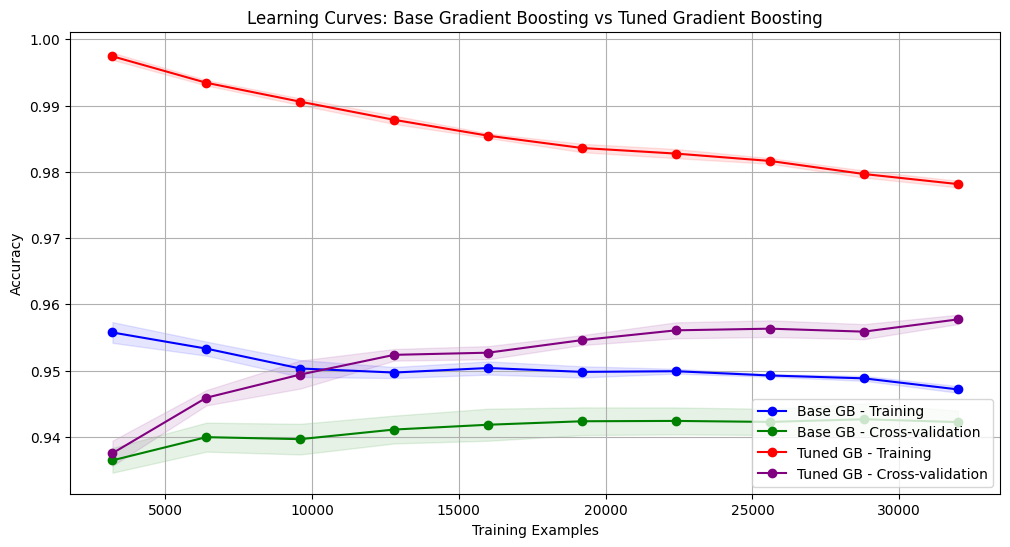


Final Scores:
Base Gradient Boosting Model:
Training Accuracy: 0.9472 (+/- 0.0010)
Cross-validation Accuracy: 0.9422 (+/- 0.0035)

Tuned Gradient Boosting Model:
Training Accuracy: 0.9782 (+/- 0.0010)
Cross-validation Accuracy: 0.9577 (+/- 0.0014)


In [24]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

def plot_comparative_learning_curves(X, y, cv):
    # Set up the figure
    plt.figure(figsize=(12, 6))
    
    # Define base and tuned models
    base_model = GradientBoostingClassifier(random_state=42)  # Default parameters
    
    # Tuned model with your best parameters
    tuned_model = GradientBoostingClassifier(
        learning_rate=0.16045488840615987,
        max_depth=7,
        max_features='sqrt',
        min_samples_leaf=8,
        min_samples_split=15,
        n_estimators=499,
        subsample=0.6203074124157587,
        random_state=42
    )
    
    # Calculate learning curves for base model
    train_sizes, train_scores_base, val_scores_base = learning_curve(
        base_model,
        X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy',
        verbose=1
    )
    
    # Calculate learning curves for tuned model
    train_sizes, train_scores_tuned, val_scores_tuned = learning_curve(
        tuned_model,
        X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy',
        verbose=1
    )
    
    # Calculate means and stds
    train_mean_base = np.mean(train_scores_base, axis=1)
    train_std_base = np.std(train_scores_base, axis=1)
    val_mean_base = np.mean(val_scores_base, axis=1)
    val_std_base = np.std(val_scores_base, axis=1)
    
    train_mean_tuned = np.mean(train_scores_tuned, axis=1)
    train_std_tuned = np.std(train_scores_tuned, axis=1)
    val_mean_tuned = np.mean(val_scores_tuned, axis=1)
    val_std_tuned = np.std(val_scores_tuned, axis=1)
    
    # Plot base model curves
    plt.plot(train_sizes, train_mean_base, 'o-', color='blue', 
             label='Base GB - Training')
    plt.fill_between(train_sizes, train_mean_base - train_std_base, 
                     train_mean_base + train_std_base, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean_base, 'o-', color='green', 
             label='Base GB - Cross-validation')
    plt.fill_between(train_sizes, val_mean_base - val_std_base,
                     val_mean_base + val_std_base, alpha=0.1, color='green')
    
    # Plot tuned model curves
    plt.plot(train_sizes, train_mean_tuned, 'o-', color='red', 
             label='Tuned GB - Training')
    plt.fill_between(train_sizes, train_mean_tuned - train_std_tuned,
                     train_mean_tuned + train_std_tuned, alpha=0.1, color='red')
    
    plt.plot(train_sizes, val_mean_tuned, 'o-', color='purple', 
             label='Tuned GB - Cross-validation')
    plt.fill_between(train_sizes, val_mean_tuned - val_std_tuned,
                     val_mean_tuned + val_std_tuned, alpha=0.1, color='purple')
    
    # Add labels and title
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves: Base Gradient Boosting vs Tuned Gradient Boosting')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Show the plot
    plt.show()
    
    # Print final scores
    print("\nFinal Scores:")
    print("Base Gradient Boosting Model:")
    print(f"Training Accuracy: {train_mean_base[-1]:.4f} (+/- {train_std_base[-1]*2:.4f})")
    print(f"Cross-validation Accuracy: {val_mean_base[-1]:.4f} (+/- {val_std_base[-1]*2:.4f})")
    print("\nTuned Gradient Boosting Model:")
    print(f"Training Accuracy: {train_mean_tuned[-1]:.4f} (+/- {train_std_tuned[-1]*2:.4f})")
    print(f"Cross-validation Accuracy: {val_mean_tuned[-1]:.4f} (+/- {val_std_tuned[-1]*2:.4f})")

# Use the function
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_comparative_learning_curves(X_train, y_train, cv)

### Naive Bayes

#### Initial Model

In [25]:
# Train Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)[:, 1]

# Print Classification Report
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_pred))

# Print ROC-AUC score
print(f"ROC-AUC Score: {roc_auc_score(y_test, nb_prob):.4f}")

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      8989
           1       0.65      0.73      0.69      1012

    accuracy                           0.93     10001
   macro avg       0.81      0.84      0.82     10001
weighted avg       0.94      0.93      0.93     10001

ROC-AUC Score: 0.9098


#### Final Naïve Bayes Model

In [26]:
# Best parameters for Naïve Bayes: {'alpha': 2.0}
# Train Naive Bayes Model
# Train Naive Bayes Model with optimized hyperparameter
nb_model2 = MultinomialNB(
    alpha=2.0  # Smoothing parameter from best parameters
)

# Fit the model
nb_model2.fit(X_train, y_train)

# Make predictions
nb_pred2 = nb_model2.predict(X_test)
nb_prob2 = nb_model2.predict_proba(X_test)[:, 1]

# Print Classification Report
print("Naïve Bayes Classification Report:\n", classification_report(y_test, nb_pred2))

# Print ROC-AUC score
print(f"ROC-AUC Score: {roc_auc_score(y_test, nb_prob2):.4f}")

Naïve Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      8989
           1       0.66      0.69      0.67      1012

    accuracy                           0.93     10001
   macro avg       0.81      0.83      0.82     10001
weighted avg       0.93      0.93      0.93     10001

ROC-AUC Score: 0.8986


#### Plot

In [27]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_comparative_learning_curves(base_nb, tuned_nb, X, y, cv):
    # Set up the figure
    plt.figure(figsize=(12, 6))
    
    # Calculate learning curves for base model
    train_sizes, train_scores_base, val_scores_base = learning_curve(
        base_nb, X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    # Calculate learning curves for tuned model
    train_sizes, train_scores_tuned, val_scores_tuned = learning_curve(
        tuned_nb, X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    # Calculate means and stds
    train_mean_base = np.mean(train_scores_base, axis=1)
    train_std_base = np.std(train_scores_base, axis=1)
    val_mean_base = np.mean(val_scores_base, axis=1)
    val_std_base = np.std(val_scores_base, axis=1)
    
    train_mean_tuned = np.mean(train_scores_tuned, axis=1)
    train_std_tuned = np.std(train_scores_tuned, axis=1)
    val_mean_tuned = np.mean(val_scores_tuned, axis=1)
    val_std_tuned = np.std(val_scores_tuned, axis=1)
    
    # Plot base model curves
    plt.plot(train_sizes, train_mean_base, 'o-', color='blue', label='Base NB - Training')
    plt.fill_between(train_sizes, train_mean_base - train_std_base, 
                     train_mean_base + train_std_base, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean_base, 'o-', color='green', label='Base NB - Cross-validation')
    plt.fill_between(train_sizes, val_mean_base - val_std_base,
                     val_mean_base + val_std_base, alpha=0.1, color='green')
    
    # Plot tuned model curves
    plt.plot(train_sizes, train_mean_tuned, 'o-', color='red', label='Tuned NB - Training')
    plt.fill_between(train_sizes, train_mean_tuned - train_std_tuned,
                     train_mean_tuned + train_std_tuned, alpha=0.1, color='red')
    
    plt.plot(train_sizes, val_mean_tuned, 'o-', color='purple', label='Tuned NB - Cross-validation')
    plt.fill_between(train_sizes, val_mean_tuned - val_std_tuned,
                     val_mean_tuned + val_std_tuned, alpha=0.1, color='purple')
    
    # Add labels and title
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves: Base Naive Bayes vs Tuned Naive Bayes')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Show the plot
    plt.show()
    
    # Print final scores
    print("\nFinal Scores:")
    print("Base Naive Bayes Model:")
    print(f"Training Accuracy: {train_mean_base[-1]:.4f} (+/- {train_std_base[-1]*2:.4f})")
    print(f"Cross-validation Accuracy: {val_mean_base[-1]:.4f} (+/- {val_std_base[-1]*2:.4f})")
    print("\nTuned Naive Bayes Model:")
    print(f"Training Accuracy: {train_mean_tuned[-1]:.4f} (+/- {train_std_tuned[-1]*2:.4f})")
    print(f"Cross-validation Accuracy: {val_mean_tuned[-1]:.4f} (+/- {val_std_tuned[-1]*2:.4f})")

# Use the function with your models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

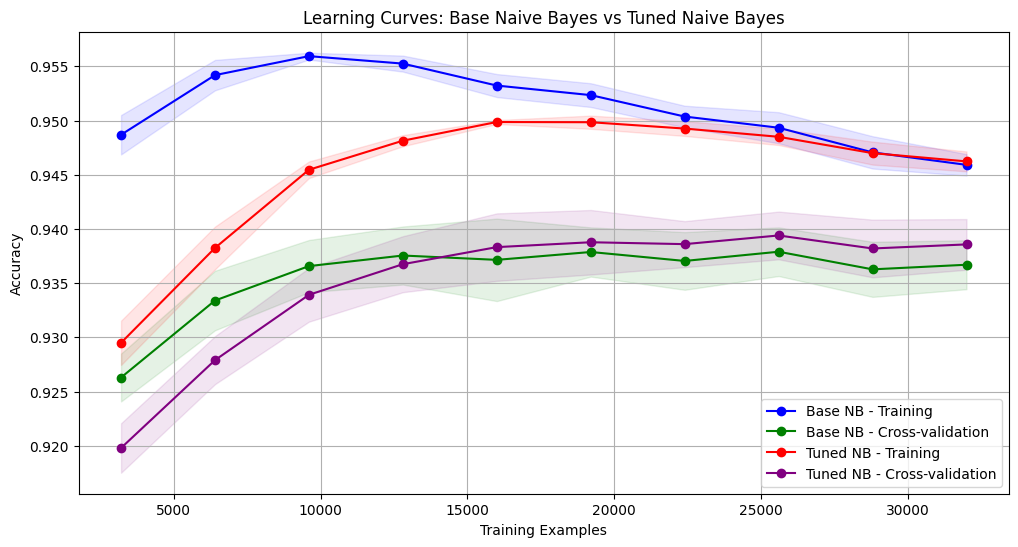


Final Scores:
Base Naive Bayes Model:
Training Accuracy: 0.9459 (+/- 0.0020)
Cross-validation Accuracy: 0.9367 (+/- 0.0045)

Tuned Naive Bayes Model:
Training Accuracy: 0.9462 (+/- 0.0018)
Cross-validation Accuracy: 0.9386 (+/- 0.0047)


In [28]:
plot_comparative_learning_curves(
    nb_model,  # Your base SVM model
    nb_model2,  # Your tuned SVM model
    X_train, 
    y_train,
    cv=cv
)

### KNN

#### Initial Model

In [29]:
# Train base KNN Model with default parameters
knn_model1 = KNeighborsClassifier()  # Default parameters

# Fit the model
knn_model1.fit(X_train, y_train)

# Make predictions
knn_pred1 = knn_model1.predict(X_test)
knn_prob1 = knn_model1.predict_proba(X_test)[:, 1]

# Print Classification Report for default model
print("Default KNN Classification Report:\n", classification_report(y_test, knn_pred1))

# Print ROC-AUC score for default model
print(f"ROC-AUC Score (Default): {roc_auc_score(y_test, knn_prob1):.4f}")



Default KNN Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      8989
           1       0.63      0.29      0.40      1012

    accuracy                           0.91     10001
   macro avg       0.78      0.64      0.68     10001
weighted avg       0.90      0.91      0.90     10001

ROC-AUC Score (Default): 0.7523


#### Final Model

In [30]:
# Best parameters for KNN: weights: distance, n_neighbors: 7, metric: cosine, algorithm: auto
# Train KNN Model with optimized hyperparameters
knn_model2 = KNeighborsClassifier(
    weights='distance',
    n_neighbors=7,
    metric='cosine',
    algorithm='auto'
)

# Fit the model
knn_model2.fit(X_train, y_train)

# Make predictions
knn_pred2 = knn_model2.predict(X_test)
knn_prob2 = knn_model2.predict_proba(X_test)[:, 1]

# Print Classification Report for tuned model
print("\nTuned KNN Classification Report:\n", classification_report(y_test, knn_pred2))

# Print ROC-AUC score for tuned model
print(f"ROC-AUC Score (Tuned): {roc_auc_score(y_test, knn_prob2):.4f}")


Tuned KNN Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      8989
           1       0.69      0.38      0.49      1012

    accuracy                           0.92     10001
   macro avg       0.81      0.68      0.72     10001
weighted avg       0.91      0.92      0.91     10001

ROC-AUC Score (Tuned): 0.8074


### Neural Networks with MLP

#### Initial Model

In [31]:
# Train MLP Classifier Model
mlp_model = MLPClassifier(
    learning_rate_init=0.001,
    hidden_layer_sizes=(100, 50),
    alpha=0.001,
    activation='relu',
    random_state=42,
    max_iter=500
)

# Fit the model
mlp_model.fit(X_train, y_train)

# Make predictions
mlp_pred = mlp_model.predict(X_test)
mlp_prob = mlp_model.predict_proba(X_test)[:, 1]

# Print Classification Report
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

# Print ROC-AUC score
print(f"ROC-AUC Score: {roc_auc_score(y_test, mlp_prob):.4f}")

MLP Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      8989
           1       0.82      0.67      0.74      1012

    accuracy                           0.95     10001
   macro avg       0.89      0.83      0.85     10001
weighted avg       0.95      0.95      0.95     10001

ROC-AUC Score: 0.9399


#### Final Model

In [32]:
# Best parameters for MLP (manually set for now)
best_params = {
    'learning_rate_init': 0.001,
    'hidden_layer_sizes': (100, 50),
    'alpha': 0.001,
    'activation': 'relu'
}

# Train MLP Classifier with optimized hyperparameters
mlp_model2 = MLPClassifier(
    **best_params,
    random_state=42,
    max_iter=500
)

# Fit the model
mlp_model2.fit(X_train, y_train)

# Make predictions
mlp_pred2 = mlp_model2.predict(X_test)
mlp_prob2 = mlp_model2.predict_proba(X_test)[:, 1]

# Print Classification Report
print("MLP Classification Report (Tuned Model):\n", classification_report(y_test, mlp_pred2))

# Print ROC-AUC score
print(f"ROC-AUC Score (Tuned Model): {roc_auc_score(y_test, mlp_prob2):.4f}")


MLP Classification Report (Tuned Model):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      8989
           1       0.82      0.67      0.74      1012

    accuracy                           0.95     10001
   macro avg       0.89      0.83      0.85     10001
weighted avg       0.95      0.95      0.95     10001

ROC-AUC Score (Tuned Model): 0.9399


#### Plot

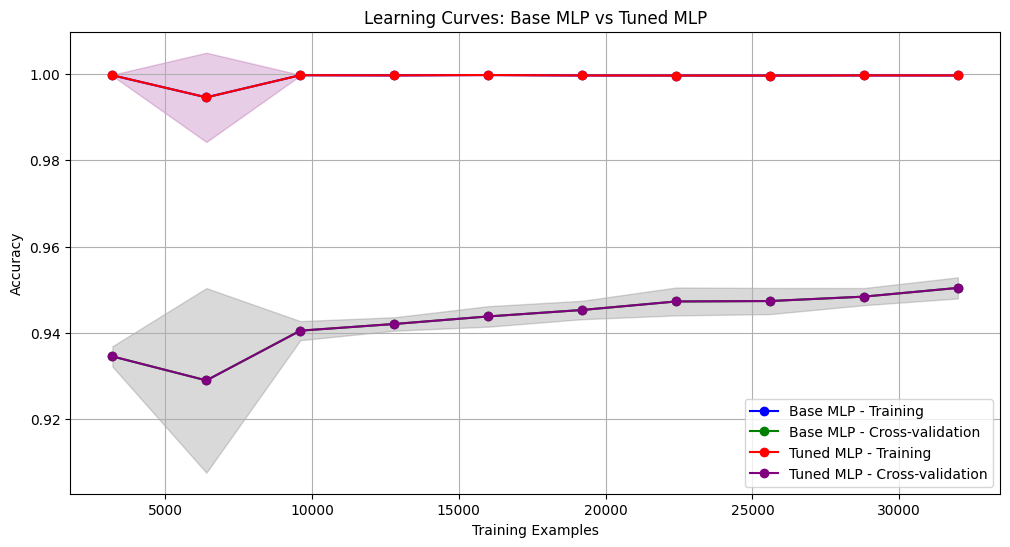


Final Scores:
Base MLP Model:
Training Accuracy: 0.9997 (+/- 0.0001)
Cross-validation Accuracy: 0.9504 (+/- 0.0049)

Tuned MLP Model:
Training Accuracy: 0.9997 (+/- 0.0001)
Cross-validation Accuracy: 0.9504 (+/- 0.0049)


In [33]:
# Function to plot comparative learning curves
def plot_comparative_learning_curves(base_model, tuned_model, X, y, cv):
    plt.figure(figsize=(12, 6))

    # Learning curve for base model
    train_sizes, train_scores_base, val_scores_base = learning_curve(
        base_model, X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    # Learning curve for tuned model
    train_sizes, train_scores_tuned, val_scores_tuned = learning_curve(
        tuned_model, X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    # Calculate means and std deviations
    train_mean_base = np.mean(train_scores_base, axis=1)
    train_std_base = np.std(train_scores_base, axis=1)
    val_mean_base = np.mean(val_scores_base, axis=1)
    val_std_base = np.std(val_scores_base, axis=1)

    train_mean_tuned = np.mean(train_scores_tuned, axis=1)
    train_std_tuned = np.std(train_scores_tuned, axis=1)
    val_mean_tuned = np.mean(val_scores_tuned, axis=1)
    val_std_tuned = np.std(val_scores_tuned, axis=1)

    # Plot base model curves
    plt.plot(train_sizes, train_mean_base, 'o-', color='blue', label='Base MLP - Training')
    plt.fill_between(train_sizes, train_mean_base - train_std_base, 
                     train_mean_base + train_std_base, alpha=0.1, color='blue')

    plt.plot(train_sizes, val_mean_base, 'o-', color='green', label='Base MLP - Cross-validation')
    plt.fill_between(train_sizes, val_mean_base - val_std_base,
                     val_mean_base + val_std_base, alpha=0.1, color='green')

    # Plot tuned model curves
    plt.plot(train_sizes, train_mean_tuned, 'o-', color='red', label='Tuned MLP - Training')
    plt.fill_between(train_sizes, train_mean_tuned - train_std_tuned,
                     train_mean_tuned + train_std_tuned, alpha=0.1, color='red')

    plt.plot(train_sizes, val_mean_tuned, 'o-', color='purple', label='Tuned MLP - Cross-validation')
    plt.fill_between(train_sizes, val_mean_tuned - val_std_tuned,
                     val_mean_tuned + val_std_tuned, alpha=0.1, color='purple')

    # Add labels and title
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves: Base MLP vs Tuned MLP')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Show the plot
    plt.show()

    # Print final scores
    print("\nFinal Scores:")
    print("Base MLP Model:")
    print(f"Training Accuracy: {train_mean_base[-1]:.4f} (+/- {train_std_base[-1]*2:.4f})")
    print(f"Cross-validation Accuracy: {val_mean_base[-1]:.4f} (+/- {val_std_base[-1]*2:.4f})")
    print("\nTuned MLP Model:")
    print(f"Training Accuracy: {train_mean_tuned[-1]:.4f} (+/- {train_std_tuned[-1]*2:.4f})")
    print(f"Cross-validation Accuracy: {val_mean_tuned[-1]:.4f} (+/- {val_std_tuned[-1]*2:.4f})")

# Use the function with your models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_comparative_learning_curves(mlp_model, mlp_model2, X_train, y_train, cv)